## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn
torch.__version__

'2.4.0+cu124'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Our dataset is a subset of Food101 dataset.
Our dataset starts with 3 classes of food and only 10% of the images (~75 training, 25 testing)

In [3]:
import requests
import zipfile
from pathlib import Path
# Setup path to a data folder
data_path = Path("data/")
image_path = data_path/"pizza_steak_sushi"
# If the imaage folder doesn't exist, download it and prepare it...
if not image_path.is_dir():
    print(f"{image_path} does not exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
# Download pizza, steak and sushi data
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
    url = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
    request = requests.get(url)
    print("downloading pizza, steak, sushi data...")
    f.write(request.content)
# Unzip the data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
    print("Unzipping pizza, steak and sushi data")
    zip_ref.extractall(image_path)
print("completed")

downloading pizza, steak, sushi data...
Unzipping pizza, steak and sushi data
completed


## 2. Becoming one with the data (data preparation and data exploration)

In [4]:
import os
def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [6]:
# Setup train and testing paths
train_dir = image_path/"train"
test_dir = image_path/"test"
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing the image

data\pizza_steak_sushi\test\sushi\2394442.jpg
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


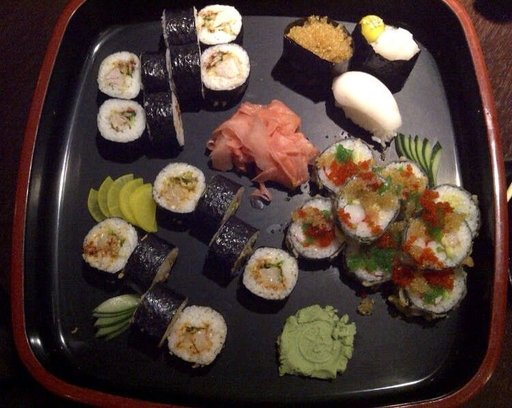

In [7]:
import random
from PIL import Image
# Set seed
random.seed(42)
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
# Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)
# Get image class from path name (the image class is the name of directory where the image is stored)
image_class = random_image_path.parent.stem
# Open Image
img = Image.open(random_image_path)
# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(-0.5, 511.5, 407.5, -0.5)

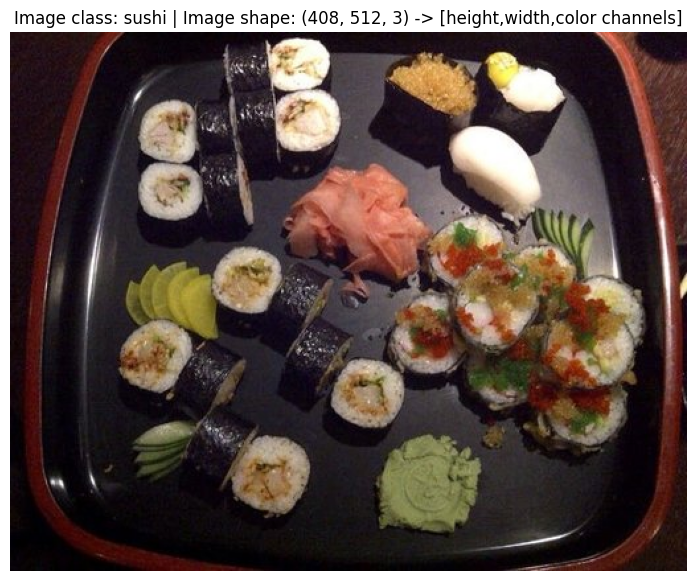

In [8]:
import matplotlib.pyplot as plt
import numpy as np
img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height,width,color channels]")
plt.axis(False)

## 3. Transforming data

1. Turn your target data into tensors
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transfroms`

In [10]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

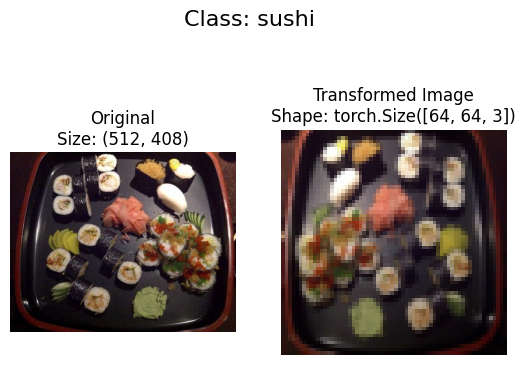

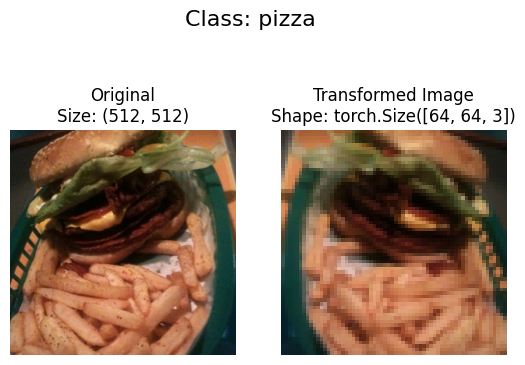

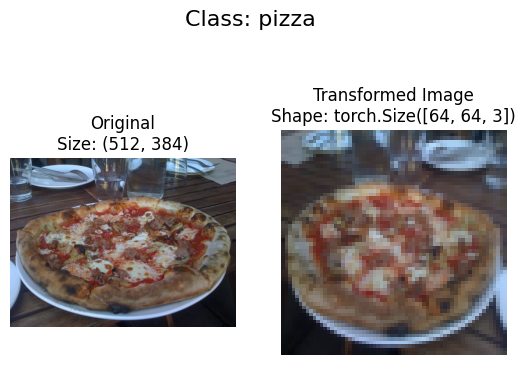

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """
    Selects random images from a path of images and loads/transforms them then plots the original vs the transformed version.
    """
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)
            # Transform and plot target image
            transformed_image = transform(f).permute(1,2,0) # change (color, height, width) -> (height, width, color)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed Image\nShape: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {image_path.parent.stem}",fontsize=16)
plot_transformed_images(image_paths=image_path_list, transform=data_transform,n=3,seed=42)

## 4. Option 1: Loading image data using `ImageFolder`

we can load image classification data using `torchvision.datasets.ImageFolder`

In [12]:
# Use ImageFolder to create dataset
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [14]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [15]:
# Check the lengths of our datasets
len(train_data), len(test_data)

(225, 75)

In [16]:
test_data.samples[0]

('data\\pizza_steak_sushi\\test\\pizza\\1152100.jpg', 0)

In [17]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image Tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image Tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [colour_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

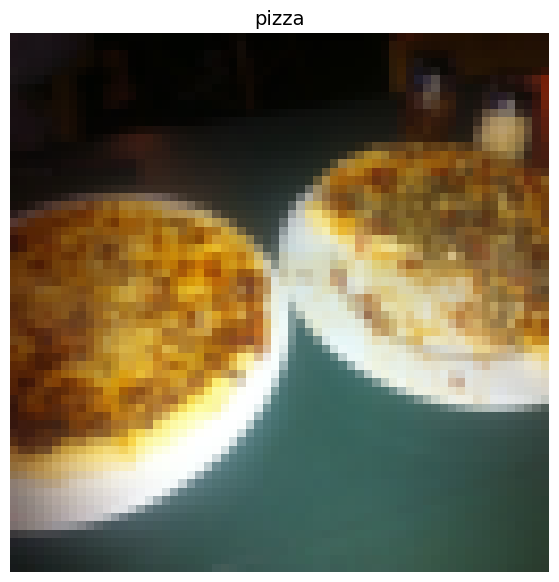

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1,2,0)
# Print out different shapes
print(f"Original shape: {img.shape} -> [colour_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")
# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into `DataLoader's`

A `DataLoader` is going to help us turn our `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [19]:
import os 
os.cpu_count()

16

In [20]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x22d351eec50>,
 <torch.utils.data.dataloader.DataLoader at 0x22d351efbe0>)

In [21]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [22]:
img, label = next(iter(train_dataloader))
# Batch size will now be 1, you can change batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with Custom `Dataset`

Pros:
* Can create a `Dataset` out of anything
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code which could be prone to errors or performance issues

In [23]:
import os
import pathlib
import torch
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

In [25]:
# Setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")
# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in target directory"""
    # 1. Get the class names by scanning the target directory."""
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory} ... please check file structure")
    # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
    class_to_idx = {class_name:i for i,class_name in enumerate(classes)}
    return classes, class_to_idx

In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [28]:
# Write a custom dataset class
from torch.utils.data import Dataset
# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attributes
        # Get all of the image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)
    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        """Opens an image via a path and returns it."""
        image_path = self.paths[index]
        return Image.open(image_path)
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        """Return the total number of samples."""
        return len(self.paths)
    # 6. Overwrite __getitem__() method to return a particular sample
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X,y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]
        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return transformed image and label
        else:
            return img, class_idx

In [29]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [31]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x22d351ed8d0>,
 <__main__.ImageFolderCustom at 0x22d351ee2f0>)

In [32]:
len(train_data), len(train_data_custom)

(225, 225)

In [33]:
len(test_data), len(test_data_custom)

(75, 75)

In [34]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [35]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [36]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustom
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


### 5.3 Create a function to display random images

In [37]:
# 1. Create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes n shouldn't be larger than 10, setting to 10 and removing shape display.")
    # 3. Set the seed
    if seed:
        random.seed(seed)
    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    # 5. Loop through random indexes and plot them with matplotlib
    plt.figure(figsize=(10,20))
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        # 7. Adjust tensor dimensions for plotting
        targ_image_adjust = targ_image.permute(1,2,0) # [color_channels, height, width] -> [height, width, color_channels]
        # Plot adjusted samples
        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

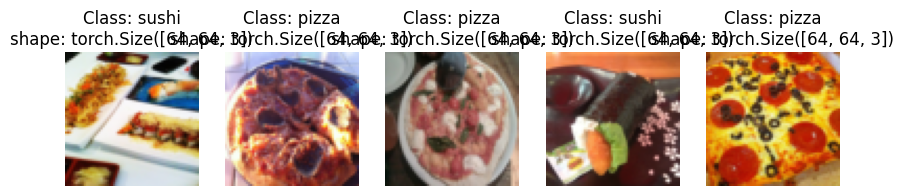

In [38]:
# Display random images from the ImageFolder created Dataset
display_random_images(train_data, n=5, classes=class_names, seed=42)

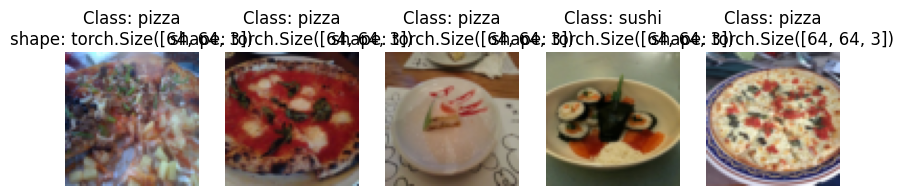

In [39]:
# Display random images from the ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=5,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader`'s

In [40]:
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x22d352634c0>,
 <torch.utils.data.dataloader.DataLoader at 0x22d35262200>)

In [41]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Lets take a look at one particular type of data augmentation used to train PyTorch visions state of the art models.

In [42]:
# Let's look at trivialaugment
from torchvision import transforms
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])
test_tranform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.ToTensor()
])

In [43]:
# Get all the image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

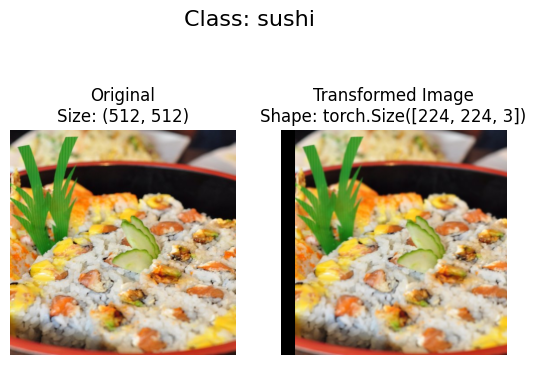

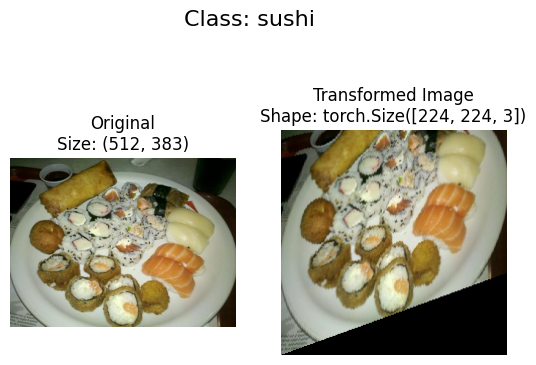

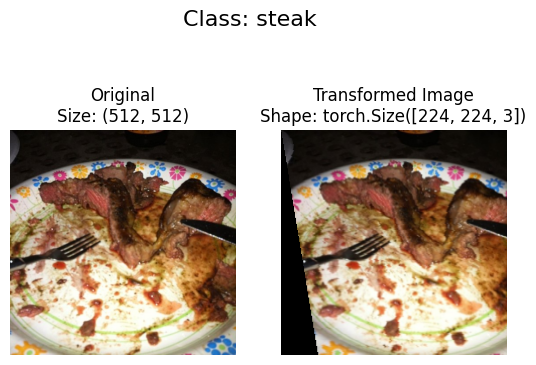

In [44]:
# Plot random images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n=3,
                        seed=None)

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [45]:
# Create simple transforms
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [46]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)
# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader
# Setup batch size and num of workers
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [47]:
### 7.2 Create TinyVGG model class
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from CNN Explainer
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(nn.Conv2d(in_channels=input_shape,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
        stride=2)
                                         )
        self.conv_block_2 = nn.Sequential(nn.Conv2d(in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
        out_channels=hidden_units,
        kernel_size=3,
        stride=1,
        padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
        stride=2)
                                         )
        self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
        out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benifits from operator fusion

In [48]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # no of color channels in our image
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on single image (to test the model)

In [49]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [50]:
# Try a formward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9127e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0238e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7226e-03,  8.3785e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2131e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [51]:
from torchinfo import summary
summary(model_0, input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5 Create train and test loops functions

In [52]:
# Create train step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    model.train()
    train_loss, train_acc = 0,0
    for batch, (X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        y_pred=model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss, train_acc

In [53]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    model.eval()
    test_loss, test_acc = 0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits,y)
            test_loss += loss.item()
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels==y).sum().item()/len(test_pred_labels))
    test_loss = test_loss/len(dataloader)
    test_acc = test_acc/len(dataloader)
    return test_loss, test_acc

In [54]:
from tqdm import tqdm
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          device=device):
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}")
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)
        print(f"Epoch {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.4f} | Test acc: {test_acc:.2f}%")
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    return results

### 7.7 Train and evaluate model 0

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 5
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)
from timeit import default_timer as timer
start_time = timer()
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        epochs=NUM_EPOCHS,
                        loss_fn=loss_fn,
                        device=device)
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|████████████████▊                                                                   | 1/5 [00:15<01:01, 15.49s/it]

Epoch 0 | Train loss: 1.1063 | Train acc: 0.30% | Test loss: 1.0983 | Test acc: 0.30%
Epoch: 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:31<00:47, 15.92s/it]

Epoch 1 | Train loss: 1.0998 | Train acc: 0.33% | Test loss: 1.0697 | Test acc: 0.54%
Epoch: 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:47<00:31, 15.70s/it]

Epoch 2 | Train loss: 1.0868 | Train acc: 0.49% | Test loss: 1.0807 | Test acc: 0.49%
Epoch: 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:02<00:15, 15.63s/it]

Epoch 3 | Train loss: 1.0843 | Train acc: 0.40% | Test loss: 1.0608 | Test acc: 0.58%
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:18<00:00, 15.73s/it]

Epoch 4 | Train loss: 1.0663 | Train acc: 0.41% | Test loss: 1.0656 | Test acc: 0.56%
Total training time: 78.634 seconds


In [56]:
model_0_results

{'train_loss': [1.1063183844089508,
  1.0998297035694122,
  1.0868210643529892,
  1.0842608362436295,
  1.0662687420845032],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.41015625],
 'test_loss': [1.0983396768569946,
  1.0696783065795898,
  1.0806868473688762,
  1.0608420769373577,
  1.0655805667241414],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of Model 0

loss curve is way to track the progress of model overtime

In [57]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [58]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionsary"""
    # Get the loss values of the results dictionary (training and test)
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]
    # Figure out how many epochs there were
    epochs = range(len(results["train_loss"]))
    # Setup a plot
    plt.figure(figsize=(15,7))
    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

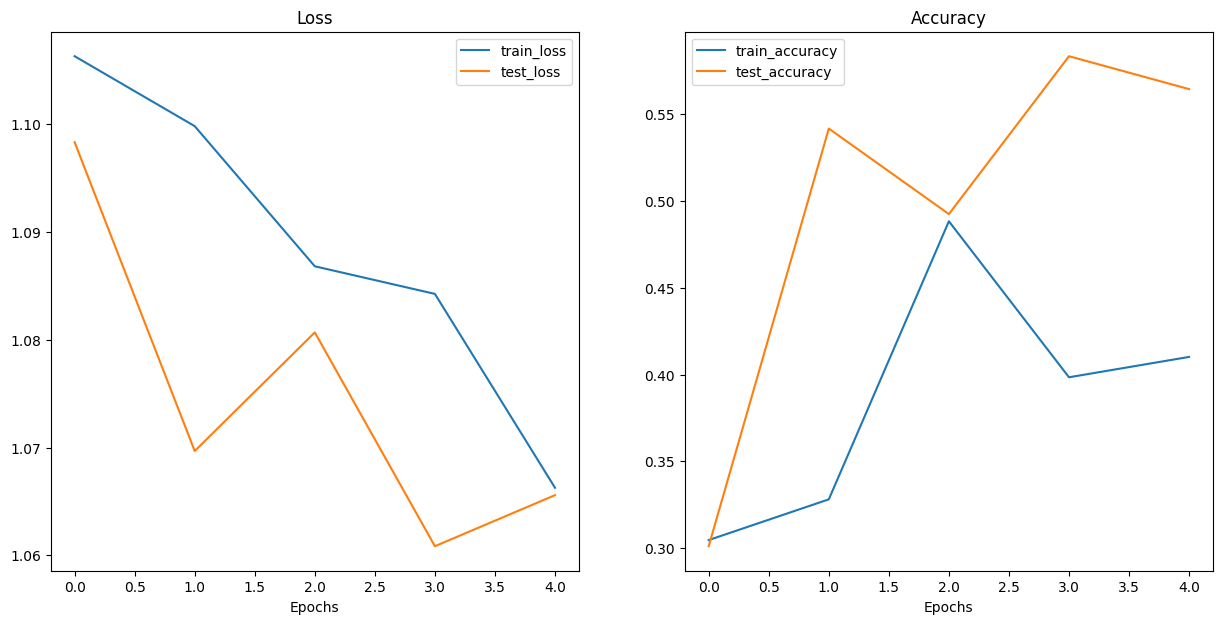

In [59]:
plot_loss_curves(model_0_results)

## 8. What should the loss curves look like?

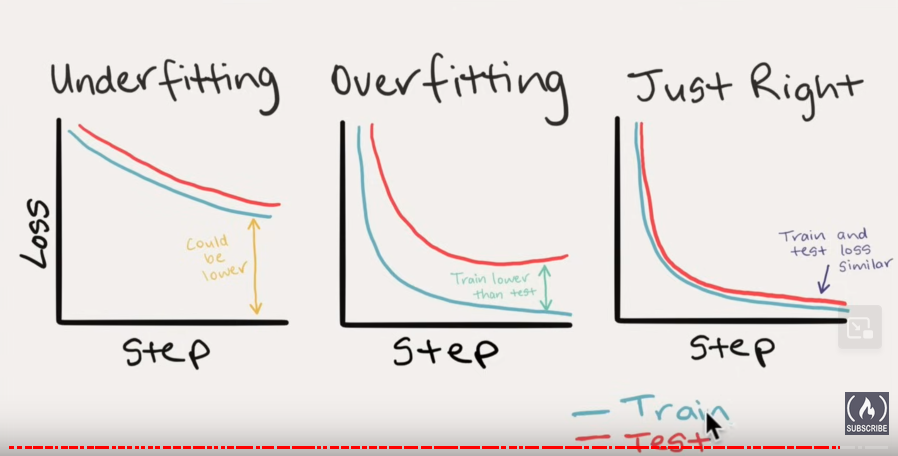

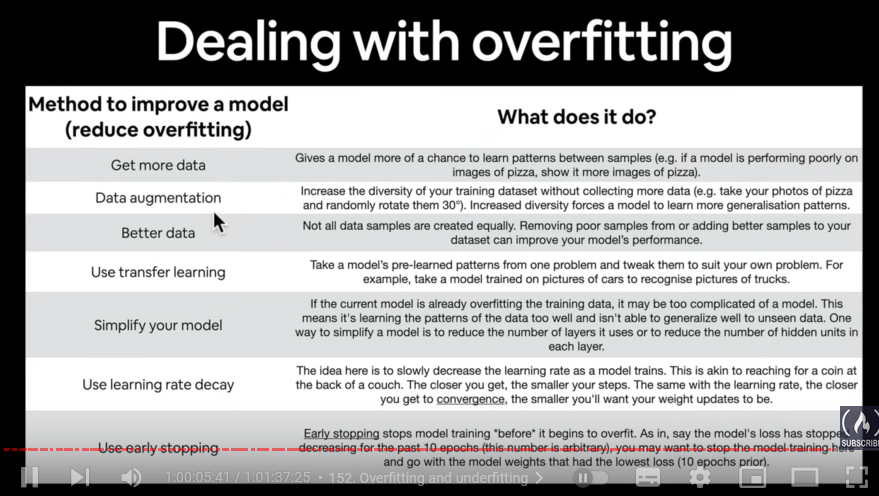

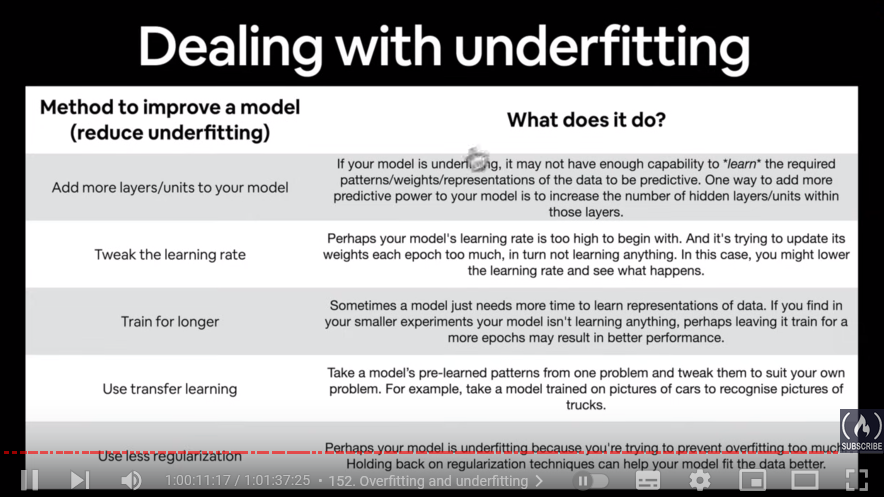

## 9. Model 1: TinyVGG with Data augmentation

### 9.1 Create transform with data augmentation

In [61]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64,64)),
                                             transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                             transforms.ToTensor()
                                            ])
test_transform_simple = transforms.Compose([transforms.Resize(size=(64,64)),
                                            transforms.ToTensor()
                                           ])

### 9.2 Create train and test `Dataset`'s and `DataLoader` with data augmentation

In [64]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                             transform=train_transform_trivial)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [65]:
# Turn our Datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE=32
NUM_WORKERS=os.cpu_count()
torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

In [66]:
# Create model 1 and send to target device
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [67]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
# Set number of epochs
NUM_EPOCHS=5
# Setup loss function and optimizer
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model_1.parameters(),
                           lr=0.001)
# Start the timer
from timeit import default_timer as timer
start_time=timer()
# Train model 1
model_1_results = train(model=model_1,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_simple,
                      optimizer=optimizer,
                      epochs=NUM_EPOCHS,
                      loss_fn=loss_fn,
                      device=device)
# End the timer and print out how long it took
end_time-timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch: 0


 20%|████████████████▊                                                                   | 1/5 [00:16<01:04, 16.06s/it]

Epoch 0 | Train loss: 1.1046 | Train acc: 0.25% | Test loss: 1.1016 | Test acc: 0.26%
Epoch: 1


 40%|█████████████████████████████████▌                                                  | 2/5 [00:31<00:46, 15.49s/it]

Epoch 1 | Train loss: 1.0764 | Train acc: 0.43% | Test loss: 1.1308 | Test acc: 0.26%
Epoch: 2


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:46<00:30, 15.35s/it]

Epoch 2 | Train loss: 1.0732 | Train acc: 0.43% | Test loss: 1.1690 | Test acc: 0.26%
Epoch: 3


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [01:01<00:15, 15.31s/it]

Epoch 3 | Train loss: 1.1234 | Train acc: 0.30% | Test loss: 1.1548 | Test acc: 0.26%
Epoch: 4


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:17<00:00, 15.49s/it]

Epoch 4 | Train loss: 1.0738 | Train acc: 0.46% | Test loss: 1.1499 | Test acc: 0.29%
Total training time for model_1: -4192.909 seconds


### 9.4 Plot the loss curves for model_1

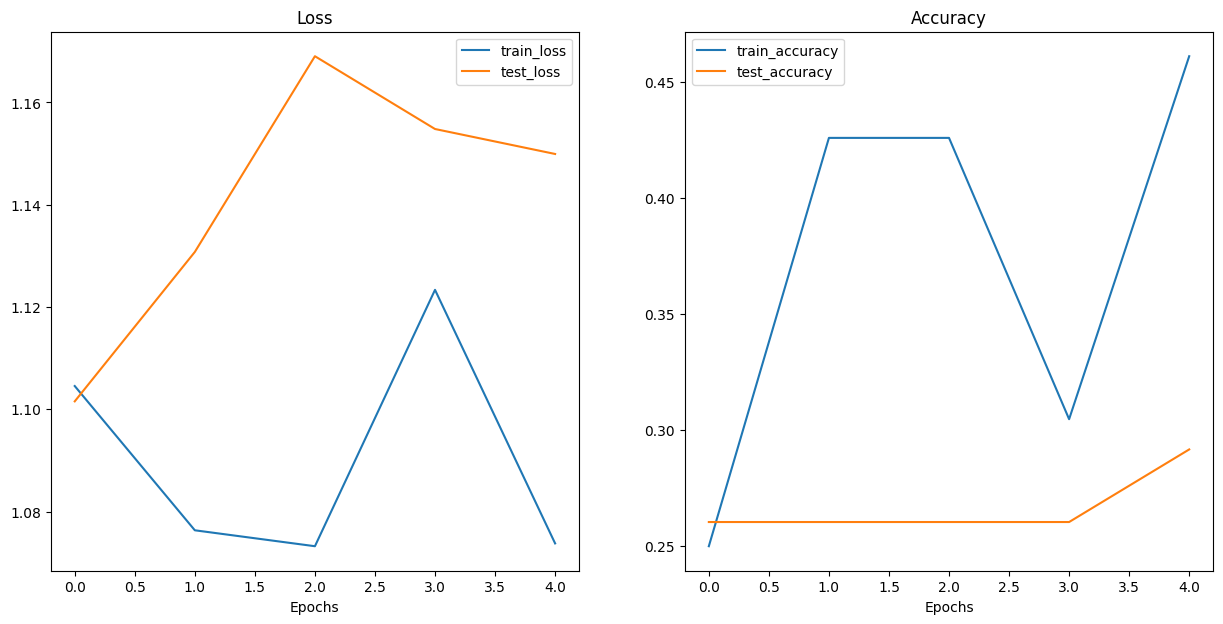

In [68]:
plot_loss_curves(model_1_results)

## 10. Compare model results

There are few different ways to do this:
* Hard coding
* PyTorch + Tensorboard
* Weights & Biases
* MLFlow

In [69]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_1_df

train_loss  train_acc  test_loss  test_acc
0    1.104559   0.250000   1.101563  0.260417
1    1.076354   0.425781   1.130778  0.260417
2    1.073239   0.425781   1.169047  0.260417
3    1.123367   0.304688   1.154815  0.260417
4    1.073787   0.460938   1.149933  0.291667

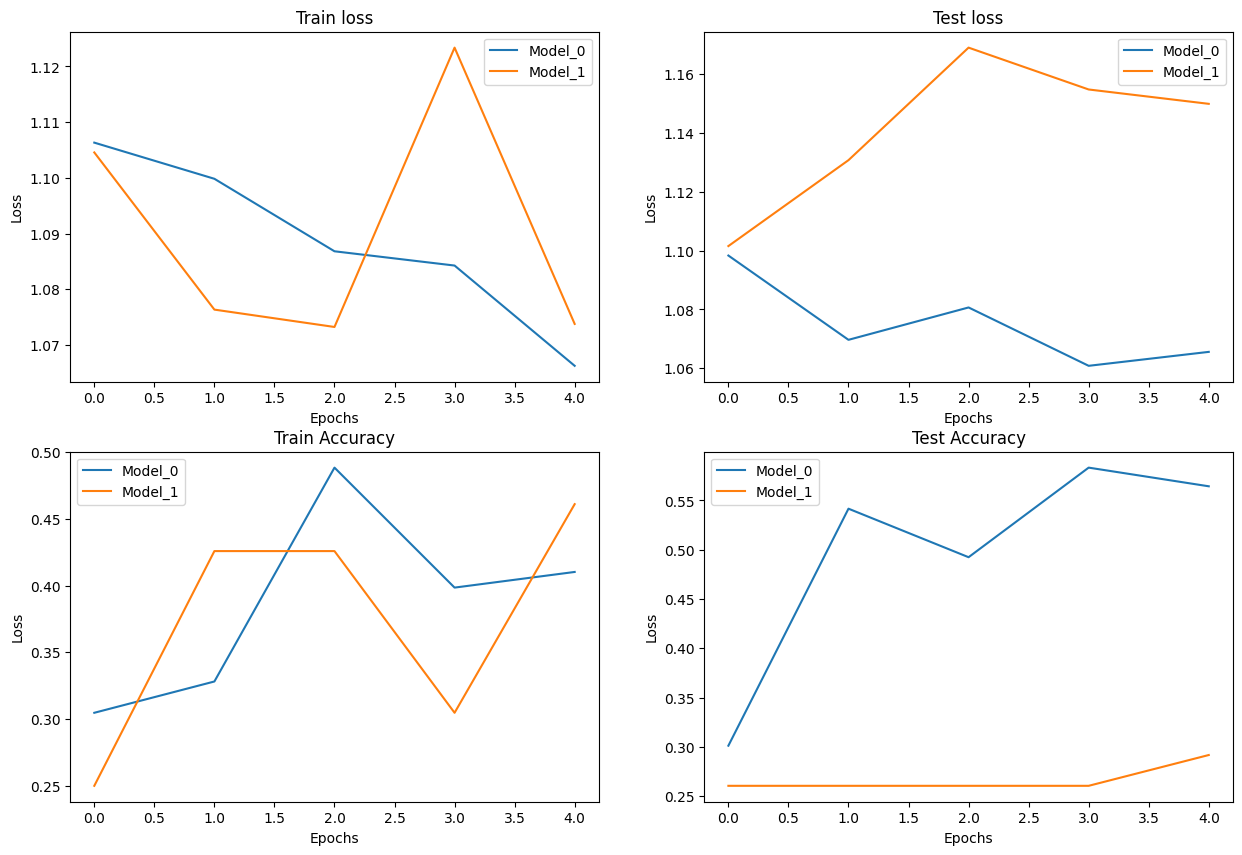

In [73]:
# Setup a plot
plt.figure(figsize=(15,10))
# Get number of epochs
epochs = range(len(model_0_df))
# Plot train loss
plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label="Model_0")
plt.plot(epochs, model_1_df["train_loss"], label="Model_1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# Plot test loss
plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label="Model_0")
plt.plot(epochs, model_1_df["test_loss"], label="Model_1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# Plot train accuracy
plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label="Model_0")
plt.plot(epochs, model_1_df["train_acc"], label="Model_1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# Plot test accuracy
plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label="Model_0")
plt.plot(epochs, model_1_df["test_acc"], label="Model_1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 11. Making a prediction on a custom image

In [74]:
# Download a custom image
import requests
# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"
# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from Github use raw link
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")

### 11.1 Loading in a custom image with PyTorch

In [77]:
import torchvision
# Read in custom image
custom_image_uint8=torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image data

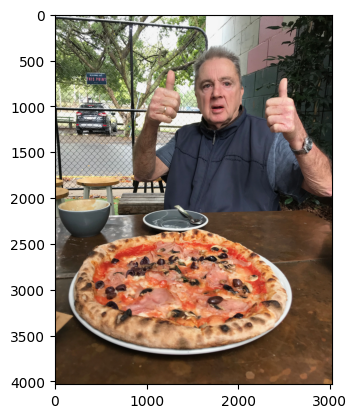

In [76]:
plt.imshow(custom_image_uint8.permute(1,2,0))

### 11.2 Making a prediction on custom image with trained PyTorch model

In [78]:
# Try to make a prediction on an image in uint8 format
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [85]:
# Load in the custom image and convert to torch.float 32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [80]:
model_1.eval()
with torch.inference_mode():
    model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

In [86]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize(size=(64,64))])
# Transform target image
custom_image_transformed = custom_image_transform(custom_image)
# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


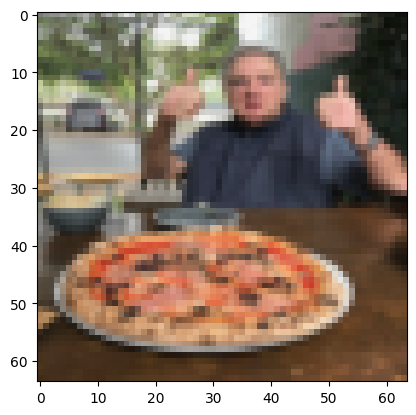

In [87]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [88]:
# This will error: no batch size
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [89]:
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [90]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0681,  0.0326, -0.2179]], device='cuda:0')

In [91]:
class_names

['pizza', 'steak', 'sushi']

>Note, to make a prediction on custom image we had to:
>* Load the image and turn it into tensor
>* Make sure the image was the same datatype as the model
>* Make sure the image ws the same shape as the data the model was trained on
>* Make sure the image was on the same device as model

In [92]:
# Convert logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3681, 0.3553, 0.2766]], device='cuda:0')

In [93]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_label

tensor([0], device='cuda:0')

In [94]:
class_names[custom_image_pred_label]

'pizza'

### 11.3 Putting custom image prediction together: building a function

In [99]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
    """Makes a prediction on target image with a trained model and plots the image and prediction"""
    # Load in the image
    target_image=torchvision.io.read_image(str(image_path)).type(torch.float32)
    # Divide the image pixel values by 255 to get them between [0,1]
    target_image=target_image/255
    # Transform if necessary
    if transform:
        target_image=transform(target_image)
    # Make sure the model is on the target device
    model.to(device)
    # Turn on eval/inference_mode and make a prediction
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to image
        target_image = target_image.unsqueeze(0)
        # Make a prediction on the image with an extra dimension
        target_image_pred = model(target_image.to(device))
    # Convert logits -> prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    # Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis("off")

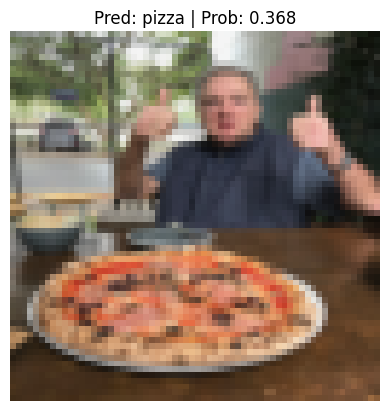

In [100]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)